<a href="https://colab.research.google.com/github/tomradch/MSCIDS_Computational_Language_Technologies/blob/main/5_0_intro_to_rnn_named_entity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition

In this notebook, we will address the problem of named entity recognition (NER).

Given a document, the goal is to locate and identify named entities into categories such as person, location, date, currency, corporation, etc.

Let's see an example using the Wikipedia page of [Guy Parmelin ](https://en.wikipedia.org/wiki/Guy_Parmelin) and [the online NLP toolkit](https://corenlp.run/):

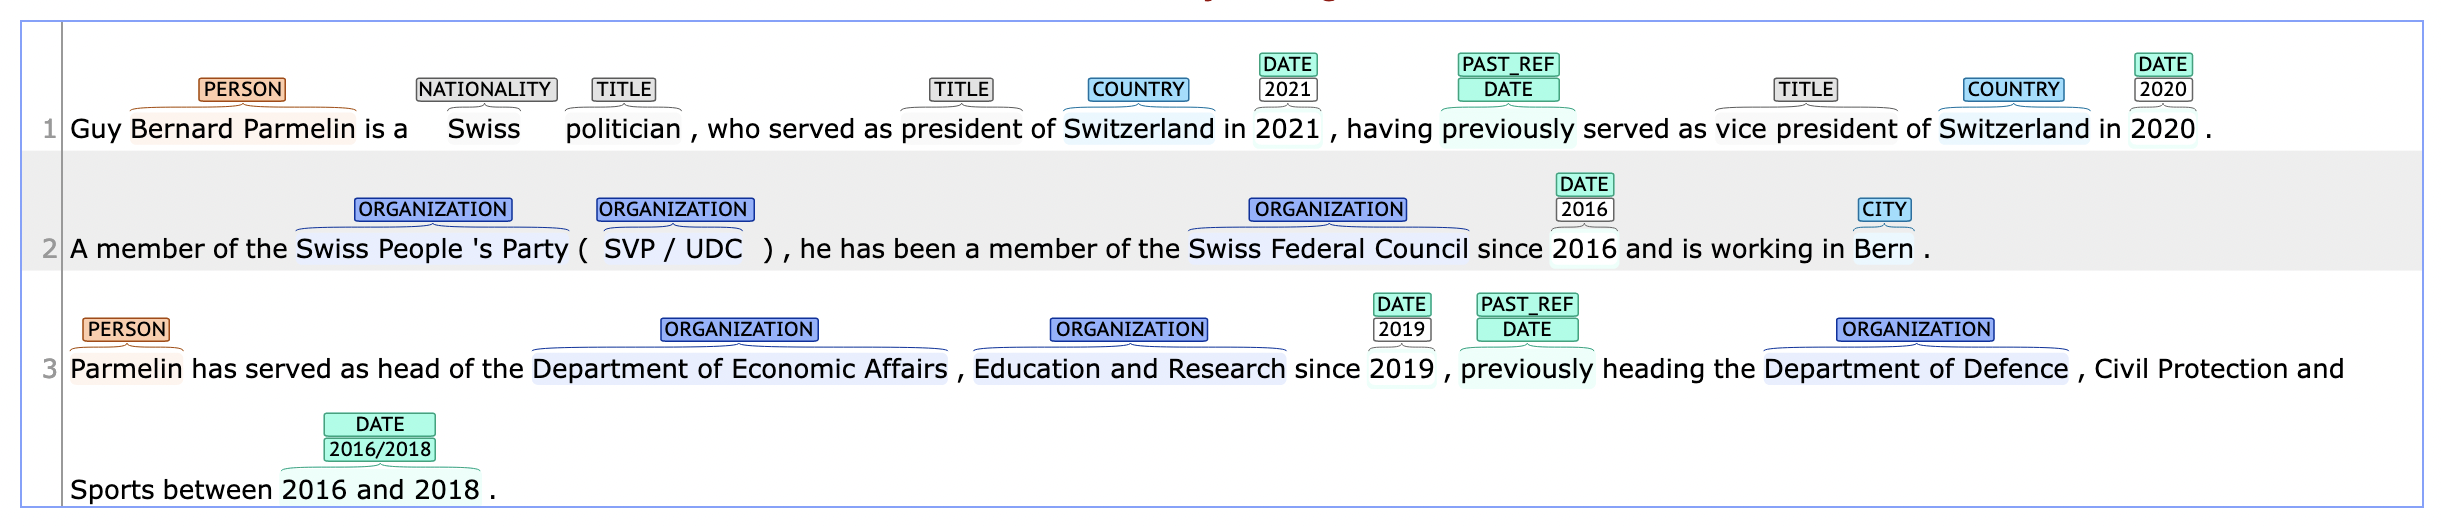

How do we represent this problem? As input, we have obviously words. What about the output?

In NER, we use the [Inside–Outside–Beginning coding scheme](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)). Basically, for each word, we will use one of the following tags:

* **O**: Not a named entity,
* **B-LOC, I-LOC, E-LOC, S-LOC**: It denotes a location,
* **B-ORG, I-ORG, E-ORG, S-ORG**: It denotes an organization,
* **B-PER, I-PER, E-PER, S-PER**: it denotes a person
* **B-MISC, I-MISC, E-MISC, S-MISC**: It denotes another type of entity.

What are those **B-**, **I-**, **E-**, and **S-**? If the entity consists of *ONE* word, we will use the code **S-**. Otherwise, we will use **B-** for the first word, **E-** for the last word, and **I-** for the word inbetween ones.

Let's represent the first two sentences above with our coding scheme:

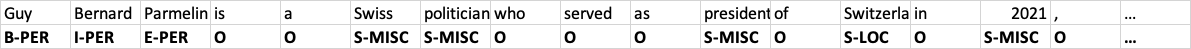

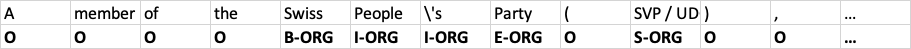

This is one possible coding scheme, that has been use in the dataset below. However, there exist other schemes as well.

Before starting, let's verify that we have a GPU available. If not, please change the runtime type **Runtime -> change runtime type -> hardware accelerator -> GPU**.

In [ ]:
!nvidia-smi

Thu May 11 06:58:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Read and split data

We will use the CONLL 2003 dataset (Sang and Meulder, 2003), which is an official one to measure the performance of NER models. Let's download the dataset and see some examples

In [ ]:
!rm eng.testa eng.testb eng.train
!wget https://raw.githubusercontent.com/glample/tagger/master/dataset/eng.testa
!wget https://raw.githubusercontent.com/glample/tagger/master/dataset/eng.testb
!wget https://raw.githubusercontent.com/glample/tagger/master/dataset/eng.train

rm: cannot remove 'eng.testa': No such file or directory
rm: cannot remove 'eng.testb': No such file or directory
rm: cannot remove 'eng.train': No such file or directory
--2023-05-11 06:58:50--  https://raw.githubusercontent.com/glample/tagger/master/dataset/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827009 (808K) [text/plain]
Saving to: ‘eng.testa’

eng.testa           100%[===================>] 807.63K  --.-KB/s    in 0.008s  

2023-05-11 06:58:50 (93.9 MB/s) - ‘eng.testa’ saved [827009/827009]

--2023-05-11 06:58:50--  https://raw.githubusercontent.com/glample/tagger/master/dataset/eng.testb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuser

In [ ]:
!ls

eng.testa  eng.testb  eng.train  sample_data


In the previous exercice, we have manually loaded all the data and created the batches ourself. PyTorch provides a `Dataset` class and a `Dataloader` to load efficiently the data, process the data if needed, and build batches automatically. Moreover, it can parallelize the pipeline. We will use one instance of `Dataset` for each data split: training, validation, and testing.

To create a dataset in PyTorch, we need to inherent from `torch.utils.data.Dataset` and implement `def __len__(self)` and `def __get__(self, index)`. The first function indicates how many samples are available while the second returns the sample at the specific index.

During the dataset creation process, we need for each sample:

1. An input (X)
2. A label or any target(s) to predict (y)
3. Optionnally an ID to identify the sample
4. Optionnally whatever information you might find useful (e.g., the full text)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch


class CONLL2033Dataset(Dataset):
    MAPPING_NER_LABELS = {
      'O': 0,
      'B-LOC': 1,
      'I-LOC': 2,
      'E-LOC': 3,
      'S-LOC': 4,
      'B-ORG': 5,
      'I-ORG': 6,
      'E-ORG': 7,
      'S-ORG': 8,
      'B-PER': 9,
      'I-PER': 10,
      'E-PER': 11,
      'S-PER': 12,
      'B-MISC':13,
      'I-MISC':14,
      'E-MISC':15,
      'S-MISC':16,
    }

    def __init__(self, file_path):
        self.data = {}
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

            tokens, labels = [], []
            for line in lines:
                # As long as there are multiple tokens per line, it means we are still reading the sentence (one sample)
                if len(line) > 2:
                    pairs = line.strip().split()
                    word = pairs[0]
                    tokens.append(word)
                    labels.append(pairs[-1])
                # We reach the end of the sentence, we store the sample
                elif len(tokens) > 0:
                    idx = len(self.data)
                    self.data[idx] = {
                        'text': ' '.join(tokens),
                        'tokens': tokens, # Pay attention that we do NOT lower the text! Any feature is important for NER
                        'ners': labels,
                        'y_ners': [CONLL2033Dataset.MAPPING_NER_LABELS[label] for label in labels], # Transformer NER to 0-16 classes
                        'idx': idx,
                        'word_idx': [], # Later for word embeddings
                    }
                    tokens, labels = [], []

    # We return the length of the dataset
    def __len__(self):
        return len(self.data)

    # We return the idx'th sample
    def __getitem__(self, idx):
        return {
            'idx': idx,
            'word_idx': torch.tensor(self.data[idx]['word_idx']).long(),
            'y_ners': torch.tensor(self.data[idx]['y_ners']).long(),
            'chars_idx': torch.tensor(self.data[idx]['chars_idx']).long(),
        }

In [ ]:
train_data = CONLL2033Dataset('eng.train')
val_data = CONLL2033Dataset('eng.testa')
test_data = CONLL2033Dataset('eng.testb')

Before going further, it is a good practice to set all the random seeds for reproducibility purposes.

In [ ]:
import numpy as np
import math
import random
import copy
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
len(train_data), len(val_data), len(test_data) 

(14986, 3465, 3683)

# Build the vocabulary and word embedding matrix

We now have all our data. Let's build the vocabulary and prepare the word-embeddings for the next steps.

In [ ]:
vocabulary = set()
for idx, sample in train_data.data.items(): # Pay attention we only use the training set!
  for token in sample['tokens']:
    vocabulary.add(token)
len(vocabulary)

23624

In this case, we do not have too many words so there is no need to filter/reduce the vocabulary (< 30k is usually good enough). Typically, we could use a frequency approach and removes words appearing less than X times.

In [ ]:
# Create the mappindg word - index and vice-versa
word2idx = {'_PAD_': 0, '_UNK_': 1}
for word in vocabulary:
  word2idx[word] = len(word2idx)
idx2word = {idx:word for word, idx in word2idx.items()}
word2idx

{'_PAD_': 0,
 '_UNK_': 1,
 '8716': 2,
 'Fabrizio': 3,
 'Sabourin': 4,
 'stand': 5,
 'Students': 6,
 'counterpart': 7,
 'Iranian': 8,
 '195': 9,
 '0.48': 10,
 'Kikinda': 11,
 'Understating': 12,
 '12.83': 13,
 'Fogarty': 14,
 'RFDG': 15,
 'Mypa-47': 16,
 '25-30': 17,
 'favour': 18,
 'naira': 19,
 'Conroy': 20,
 'pool': 21,
 'temperature': 22,
 'SPRINT': 23,
 'Likkason': 24,
 'brackets': 25,
 '.540': 26,
 '19,560': 27,
 'freezer': 28,
 'Alleyne': 29,
 'MEXICO': 30,
 'entitled': 31,
 'park': 32,
 '8.70': 33,
 'intentionally': 34,
 'Wada': 35,
 'burn': 36,
 'Ayr': 37,
 'Okada': 38,
 'flushed': 39,
 'validity': 40,
 '.602': 41,
 'Jet': 42,
 'liquids': 43,
 'Apex': 44,
 'Russians': 45,
 'airports': 46,
 'Halford': 47,
 'Okuda': 48,
 'pensions': 49,
 '40.': 50,
 'move': 51,
 'Rodriguez': 52,
 'strategic': 53,
 'ALEXANDROUPOLIS': 54,
 '15-10': 55,
 '10-30': 56,
 '80.70': 57,
 'Inquiry': 58,
 'morose': 59,
 'Karen': 60,
 'Nebraska': 61,
 '5-203': 62,
 'Angel': 63,
 'starker': 64,
 '1:04.834': 6

In [ ]:
idx2word

{0: '_PAD_',
 1: '_UNK_',
 2: '8716',
 3: 'Fabrizio',
 4: 'Sabourin',
 5: 'stand',
 6: 'Students',
 7: 'counterpart',
 8: 'Iranian',
 9: '195',
 10: '0.48',
 11: 'Kikinda',
 12: 'Understating',
 13: '12.83',
 14: 'Fogarty',
 15: 'RFDG',
 16: 'Mypa-47',
 17: '25-30',
 18: 'favour',
 19: 'naira',
 20: 'Conroy',
 21: 'pool',
 22: 'temperature',
 23: 'SPRINT',
 24: 'Likkason',
 25: 'brackets',
 26: '.540',
 27: '19,560',
 28: 'freezer',
 29: 'Alleyne',
 30: 'MEXICO',
 31: 'entitled',
 32: 'park',
 33: '8.70',
 34: 'intentionally',
 35: 'Wada',
 36: 'burn',
 37: 'Ayr',
 38: 'Okada',
 39: 'flushed',
 40: 'validity',
 41: '.602',
 42: 'Jet',
 43: 'liquids',
 44: 'Apex',
 45: 'Russians',
 46: 'airports',
 47: 'Halford',
 48: 'Okuda',
 49: 'pensions',
 50: '40.',
 51: 'move',
 52: 'Rodriguez',
 53: 'strategic',
 54: 'ALEXANDROUPOLIS',
 55: '15-10',
 56: '10-30',
 57: '80.70',
 58: 'Inquiry',
 59: 'morose',
 60: 'Karen',
 61: 'Nebraska',
 62: '5-203',
 63: 'Angel',
 64: 'starker',
 65: '1:04.834

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-05-11 06:58:57--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-11 06:58:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.65MB/s    in 2m 49s  

2023-05-11 07:01:48 (4.86 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# Easier to load with gensim
WORD_DIM = 100
from gensim.models import KeyedVectors
#word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Glove
from gensim.scripts.glove2word2vec import glove2word2vec
_ = glove2word2vec('glove.6B.100d.txt', 'glove.6B.100d_w2v.txt')
word2vec = KeyedVectors.load_word2vec_format('glove.6B.100d_w2v.txt', binary=False)

<ipython-input-14-f81eca48fb0f>:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  _ = glove2word2vec('glove.6B.100d.txt', 'glove.6B.100d_w2v.txt')


In [ ]:
# Now we create the word embedding matrix and copy from word2vec embeddings!

# Initialize randomly the word embedding matrix
word_embeddings = np.random.rand(len(word2idx), WORD_DIM)

# Set the values to 0 for padding
word_embeddings[word2idx['_PAD_']] = np.zeros(WORD_DIM)

# Copy from word2vec
for word in vocabulary:
  if word in word2vec:
    word_embeddings[word2idx[word], :] = word2vec[word]
word_embeddings.shape

(23626, 100)

# Process the data.

Now, we can add the word embedding indeces to our data to be fed to the model. 

Let's use the attribute `word_idx` for all samples. In case a word is unknown, we will simply replace it with the work "_UNK_".

In [ ]:
# We add the word indeces to all data splits
for split_data in [train_data.data, val_data.data, test_data.data]:
  for idx, sample in split_data.items():
    sample['word_idx'] = []
    for token in sample['tokens']:
      # If a word is not in our vocabulary, we put the UNK token instead
      sample['word_idx'].append(word2idx[token] if token in word2idx else word2idx['_UNK_'])

Great! We are nearly there. The last problem to address is to have the same length for the reviews. A simple way is to pad each sample until reaching the maximum length.

Let's see what is the longest review so far.

In [ ]:
max(len(sample['tokens']) for idx, sample in train_data.data.items()), \
max(len(sample['tokens']) for idx, sample in val_data.data.items()), \
max(len(sample['tokens']) for idx, sample in test_data.data.items())

(113, 109, 124)

Now, the last step is to pad all reviews to 124 tokens!

In [ ]:
PAD_LENGTH = 124

for split_data in [train_data.data, val_data.data, test_data.data]:
  for idx, sample in split_data.items():
    while len(sample['word_idx']) < PAD_LENGTH:
      sample['word_idx'].append(word2idx['_PAD_'])
    

      # PAY ATTENTION!
      # Because we are padding our inputs, we also have to pad the output! Indeed, each word has a label
      # Therefore adding "_PAD_" would compute the prediction for it.
      # There is a way to not include this prediction in the lost function.
      # We will add a special value like -100 (it will be clearer later why).
      sample['y_ners'].append(-100)


    # Sanity check
    assert len(sample['word_idx']) == PAD_LENGTH

# Bonus: Character embeddings

In [ ]:
all_characters = set()
for idx, sample in train_data.data.items():
  for token in sample['tokens']:
    for char in token:
      all_characters.add(char)
print(all_characters)

{'&', 'D', 'w', '[', 'X', '8', '(', 'P', '=', ',', 'B', 'p', 'S', 'R', '2', 'O', 'U', '3', ':', 's', '9', 'd', 'F', '+', 'C', '"', '7', 'q', '.', '?', 'f', ';', 'K', 'E', 'm', 'o', 'V', 'u', '5', 'Y', 'G', 'J', 'W', '`', 'Z', 'I', '%', '4', 'k', 'b', 'N', 'a', 'j', '0', 'c', 'y', ')', 'L', 'z', '$', 'H', ']', '6', 't', 'l', 'e', 'h', '1', 'M', 'x', 'T', '-', '*', 'Q', 'n', 'i', 'g', 'A', "'", '@', '!', 'r', '/', 'v'}


In [ ]:
char2idx = {'_PAD_': 0, '_UNK_': 1}
for char in all_characters:
  char2idx[char] = len(char2idx)
idx2char = {idx:char for char, idx in char2idx.items()}
char2idx

{'_PAD_': 0,
 '_UNK_': 1,
 '&': 2,
 'D': 3,
 'w': 4,
 '[': 5,
 'X': 6,
 '8': 7,
 '(': 8,
 'P': 9,
 '=': 10,
 ',': 11,
 'B': 12,
 'p': 13,
 'S': 14,
 'R': 15,
 '2': 16,
 'O': 17,
 'U': 18,
 '3': 19,
 ':': 20,
 's': 21,
 '9': 22,
 'd': 23,
 'F': 24,
 '+': 25,
 'C': 26,
 '"': 27,
 '7': 28,
 'q': 29,
 '.': 30,
 '?': 31,
 'f': 32,
 ';': 33,
 'K': 34,
 'E': 35,
 'm': 36,
 'o': 37,
 'V': 38,
 'u': 39,
 '5': 40,
 'Y': 41,
 'G': 42,
 'J': 43,
 'W': 44,
 '`': 45,
 'Z': 46,
 'I': 47,
 '%': 48,
 '4': 49,
 'k': 50,
 'b': 51,
 'N': 52,
 'a': 53,
 'j': 54,
 '0': 55,
 'c': 56,
 'y': 57,
 ')': 58,
 'L': 59,
 'z': 60,
 '$': 61,
 'H': 62,
 ']': 63,
 '6': 64,
 't': 65,
 'l': 66,
 'e': 67,
 'h': 68,
 '1': 69,
 'M': 70,
 'x': 71,
 'T': 72,
 '-': 73,
 '*': 74,
 'Q': 75,
 'n': 76,
 'i': 77,
 'g': 78,
 'A': 79,
 "'": 80,
 '@': 81,
 '!': 82,
 'r': 83,
 '/': 84,
 'v': 85}

In [ ]:
CHAR_DIM = 32

# Initialize randomly the word embedding matrix
char_embeddings = np.random.rand(len(idx2char), CHAR_DIM)

# Set the values to 0 for padding
char_embeddings[char2idx['_PAD_']] = np.zeros(CHAR_DIM)

In [ ]:
longest_words = list(sorted({(len(token), token) for idx, sample in train_data.data.items() for token in sample['tokens']}, reverse=True))[:100]
longest_words

[(61, '-------------------------------------------------------------'),
 (60, '------------------------------------------------------------'),
 (52, 'DAY--COMPANY----PERIOD--CONSENSUS----RANGE-------PVS'),
 (50, 'Company-------------Price---Broker----------------'),
 (34, '----------------------------------'),
 (32, '--------------------------------'),
 (27, 'Amsterdam-Rotterdam-Antwerp'),
 (25, 'three-month-to-three-year'),
 (25, 'internationally-sponsored'),
 (25, '-------------------------'),
 (24, '------------------------'),
 (23, 'www.internetstartup.com'),
 (23, 'derivatives@reuters.com'),
 (22, 'undersecretary-general'),
 (22, 'stronger-than-expected'),
 (22, 'Undersecretary-General'),
 (21, 'municipality-in-exile'),
 (21, 'Republican-controlled'),
 (21, 'Doetinchem-Doetinchem'),
 (21, '---------------------'),
 (20, 'government-appointed'),
 (20, 'Tikhomirov-Maskhadov'),
 (20, 'SCOREBOARD-AUSTRALIA'),
 (20, 'Republican-initiated'),
 (20, 'Better-than-expected'),
 (19, 'separat

We will consider that a word has maximum 16 chars (e.g., disqualification). In practice, there might be more preprocessing to do, which could potentially reduce noise.

In [ ]:
PAD_CHAR_LENGTH = 16

for split_data in [train_data.data, val_data.data, test_data.data]:
  for idx, sample in split_data.items():
    sample['chars_idx'] = []
    for token in sample['tokens']:
      # We trunk in case we have more chars
      chars = [(char2idx[char] if char in char2idx else char2idx['_UNK_']) for char in token][:PAD_CHAR_LENGTH]
      
      # Transform chars into indeces
      sample['chars_idx'].append(chars)

      # Pad chars with PAD tokens
      while len(sample['chars_idx'][-1]) < PAD_CHAR_LENGTH:
        sample['chars_idx'][-1].append(char2idx['_PAD_'])
    
    # Pad with empty chars to reach the padding length of the sentence
    while len(sample['chars_idx']) < PAD_LENGTH:
      sample['chars_idx'].append([0 for _ in range(PAD_CHAR_LENGTH)])
    
    # Sanity check
    assert len(sample['chars_idx']) == PAD_LENGTH
    for chars in sample['chars_idx']:
      assert len(chars) == PAD_CHAR_LENGTH

# Modeling

Could you explain what are we modeling?

In [ ]:
class MyNERModel(nn.Module):
    def __init__(self, dropout, hidden_dim, classes_num, words_num, word_dim, chars_num, char_dim):
        super(MyNERModel, self).__init__()

        self.word_embedding = nn.Embedding(num_embeddings=words_num, embedding_dim=word_dim)
        
        # Our main component
        self.word_rnn = nn.RNN(input_size=word_dim,
                               hidden_size=hidden_dim,
                               num_layers=1,
                               batch_first=True,
                               dropout=0, # No dropout; it is complicated for RNNs. Do you have an intuition why?
                               bidirectional=False)
        
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Tanh()

        # The last layer to compute the probabilities for the output classes
        self.final_layer = nn.Linear(in_features=hidden_dim, out_features=classes_num)

        # Bonus
        self.char_embedding = nn.Embedding(num_embeddings=chars_num, embedding_dim=char_dim)
        self.char_rnn = nn.RNN(input_size=char_dim,
                               hidden_size=hidden_dim,
                               num_layers=1,
                               batch_first=True,
                               dropout=0, # No dropout; it is complicated for RNNs. Do you have an intuition why?
                               bidirectional=False)
        
        
    def forward(self, x):
        x_words = self.word_embedding(x['word_idx']) # Convert into word embeddings
        
        # BONUS: How to use the output of self.char_rnn and concatenate with x_words?
        # ???
        
        x_words = self.dropout(x_words)
        
        # If you check the documentation https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        # hidden will be the final hidden state (BxH) 
        # whereas output contains the values of the hidden states for each time step (BxLxH)
        output, last_hidden_state = self.word_rnn(x_words)
        
        output = self.activation(output)
        output = self.dropout(output)

        # Compute the log probabilities. We do not compute the probabilities with Softmax because depending the loss function, we might require unnormalized or probabilities.
        # Worst case, we can always apply F.softmax(output, dim=-1) later.
        logits = self.final_layer(output)
        return logits

Let's see if our model can compute a foward pass

In [ ]:
# Example of a batch=1 and 6 word indeces
input = {'word_idx': torch.tensor([[0,1,2,3,4,5]])}
input

{'word_idx': tensor([[0, 1, 2, 3, 4, 5]])}

In [ ]:
ner = MyNERModel(dropout=0.3, hidden_dim=50, classes_num=3, words_num=6, word_dim=10, chars_num=6, char_dim=5)
logits = ner(input)
logits, logits.size()

(tensor([[[ 0.0764, -0.1668,  0.0908],
          [ 0.1358, -0.1125, -0.0273],
          [-0.2773, -0.3301,  0.0274],
          [-0.1854, -0.0084,  0.3041],
          [ 0.4168, -0.0840,  0.1346],
          [-0.4787,  0.0061,  0.3210]]], grad_fn=<ViewBackward0>),
 torch.Size([1, 6, 3]))

Great! The model seems to work and is able to compute the tag probability of a word.

# Loss function

What is the loss to use to optimize the model? Because we are doing classification, the most natural one is to use the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=cross%20entropy#torch.nn.CrossEntropyLoss). 

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=-100)

**ATTENTION**: What is this ignore_index? In this can of task, where the output depends of the input length, we use PADDING. However, we do not want the prediction for the PAD words to have any influence. One way of doing this is to use a special value for the class (here -100) that will be ignored in the computation loss! See the documentation for more information.

Let's see a toy example

In [ ]:
def inv_softmax(x):
  return x.log() + math.log(10.)

pred = inv_softmax(torch.tensor([[0.0, 1.0], [0.25, 0.75], [0.5, 0.5], [0.75, 0.25], [0.99, 0.01]])) # Assumed this has been computed by a model
gold = torch.tensor([ 1       ,   0          , 1         ,  0          ,  1]) 

In [ ]:
F.cross_entropy(pred, gold, reduction='none')

tensor([-0.0000, 1.3863, 0.6931, 0.2877, 4.6052])

In [ ]:
F.cross_entropy(pred, gold, reduction='none', ignore_index=0)

tensor([-0.0000, 0.0000, 0.6931, 0.0000, 4.6052])

In [ ]:
F.cross_entropy(pred, gold, reduction='none', ignore_index=1)

tensor([0.0000, 1.3863, 0.0000, 0.2877, 0.0000])

As you see, labels with value "ignore_index" have a score of 0!

# Metric

As our task implies multi classification and the distribution of data is unbalanced originally, we will use the macro F1 score. Basically, it consists of the average F1 score for each class. (The micro F1 score applies a weighted average).

In [ ]:
from sklearn.metrics import f1_score
def compute_f1(preds, golds):
  return f1_score(preds, golds, average='macro')

# Putting all together

We now have the model, the data, and the loss function. We are ready to implement the training loop.

In [ ]:
BATCH_SIZE = 256

# We initialize our model
model = MyNERModel(dropout=0.3, 
                   hidden_dim=128, 
                   classes_num=len(train_data.MAPPING_NER_LABELS), 
                   words_num=len(word2idx), 
                   word_dim=WORD_DIM, 
                   chars_num=len(char2idx),
                   char_dim=CHAR_DIM)

# Copy the word embedding matrix
model.word_embedding.weight.data = torch.from_numpy(word_embeddings).float()
model.word_embedding.weight.requires_grad = False # We do NOT want to fine-tune the word embedding

# BONUS
# Copy the char embedding matrix (that was ramdonly initialized)
model.char_embedding.weight.data = torch.from_numpy(char_embeddings).float()
model.char_embedding.weight.requires_grad = True # We DO want to fine-tune the char embedding as they were randomly initialized.

In [ ]:
# We initialize our optimizer to update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8) # L2 = weight_decay

In [ ]:
# We can load our dataset using a dataloader
train_loader = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        shuffle=True, # Pay attention that we can shuffle the samples for training
        num_workers=0, # And specify how many working we want. 0/1 = 1
        drop_last=False) # Finally, it is possible to drop the last batch if its size is smaller than args.batch_size. In some applications, it is easier to ignore it instead of handling it.

val_loader = DataLoader(
        val_data,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

test_loader = DataLoader(
        test_data,
        batch_size=BATCH_SIZE,
        shuffle=False, # Pay attention here that the data is not shuffled.
        num_workers=0, 
        drop_last=False)

In [ ]:
# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize the loss function
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=-100)

best_epoch = 0
best_val_so_far = 0
test_perf = 0


# TRAINING LOOP
for epoch in range(250):
  print('------------------------------------------------------------------------')
  print('Epoch: {}'.format(epoch))

  # TRAIN
  # We set the model in train mode. It will store information to compute the gradients
  # Also, the implementation of dropout, batchnorm, etc is different at training and inference time.
  model.train()

  train_losses = []
  # Pay attention how the data loading become easiers!
  for idx, batch in tqdm.tqdm(enumerate(train_loader), desc='Training'):
    # move them to GPU
    batch['word_idx'] = batch['word_idx'].to(device)
    batch['chars_idx'] = batch['chars_idx'].to(device)
    batch['y_ners'] = batch['y_ners'].to(device) #BxL

    # Compute the model output and the loss
    y_logits = model(batch) #BxLxC (17)
    # We have to "flatten" the predictions because CE only handle tensors like BxC and B
    loss = criterion(y_logits.view(-1, len(train_data.MAPPING_NER_LABELS)), batch['y_ners'].view(-1))

    # Update model parameters
    optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
    loss.backward() # Now that gradients have been empties, we compute the new ones using the loss.
    optimizer.step() # We do gradient update with our optimization function (i.e., the weights of the model are updated).
  
    train_losses.append(loss.item())
  
  
  # VAL + TEST
  val_test_losses = {'val': [], 'test': []}
  val_test_f1 = {'val': [], 'test': []}
  
  # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
  model.eval()

  # We do not store information relative to gradients as we do not update the model.
  # That's the reason why inference requires less memory and is faster.
  with torch.no_grad():
    for split_data, data in [('val', val_loader), ('test', test_loader)]:
      # Pay attention how the data loading become easiers!
      for idx, batch in tqdm.tqdm(enumerate(data), desc=split_data.capitalize()):

        # move them to GPU
        batch['word_idx'] = batch['word_idx'].to(device)
        batch['chars_idx'] = batch['chars_idx'].to(device)
        batch['y_ners'] = batch['y_ners'].to(device) #BxL

        # Compute the model output and the loss
        y_logits = model(batch) #BxLxC (17)
        # We have to "flatten" the predictions because CE only handle tensors like BxC and B
        loss = criterion(y_logits.view(-1, len(train_data.MAPPING_NER_LABELS)), batch['y_ners'].view(-1))

        val_test_losses[split_data].append(loss.item())

        # Compute the macro f1 to evaluate our model
        y_probs = F.softmax(y_logits, dim=-1)
        y_pred = torch.argmax(y_logits, dim=-1)

        f1 = compute_f1(y_pred.view(-1).cpu().numpy(), batch['y_ners'].view(-1).cpu().numpy())
        val_test_f1[split_data].append(f1)
  
  # Monitoring
  print('Train loss: {:.4f}'.format(np.mean(train_losses)))
  print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
  print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
  print()

  val_f1 = np.mean(val_test_f1['val'])
  test_f1 = np.mean(val_test_f1['test'])
  print('Val   Macro F1: {:.4f}'.format(val_f1))
  print('Test  Macro F1: {:.4f}'.format(test_f1))
  print()

  if best_val_so_far < val_f1:
    best_val_so_far = val_f1
    test_perf = test_f1
    best_epoch = epoch
  
  print('Best Epoch: {}, best val macro F1: {:.4f}, test macro F1: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
  print()
  print()

------------------------------------------------------------------------
Epoch: 0


Training: 59it [00:06,  9.09it/s]
Val: 14it [00:01, 10.58it/s]
Test: 15it [00:01, 11.38it/s]


Train loss: 0.8091
Val   loss: 0.4949
Test  loss: 0.5300

Val   Macro F1: 0.0641
Test  Macro F1: 0.0582

Best Epoch: 0, best val macro F1: 0.0641, test macro F1: 0.0582


------------------------------------------------------------------------
Epoch: 1


Training: 59it [00:06,  9.21it/s]
Val: 14it [00:01, 11.16it/s]
Test: 15it [00:01, 11.30it/s]


Train loss: 0.4307
Val   loss: 0.4596
Test  loss: 0.4973

Val   Macro F1: 0.0897
Test  Macro F1: 0.0715

Best Epoch: 1, best val macro F1: 0.0897, test macro F1: 0.0715


------------------------------------------------------------------------
Epoch: 2


Training: 59it [00:06,  9.18it/s]
Val: 14it [00:01, 11.02it/s]
Test: 15it [00:01, 11.12it/s]


Train loss: 0.4080
Val   loss: 0.4478
Test  loss: 0.4854

Val   Macro F1: 0.1136
Test  Macro F1: 0.0932

Best Epoch: 2, best val macro F1: 0.1136, test macro F1: 0.0932


------------------------------------------------------------------------
Epoch: 3


Training: 59it [00:05, 10.74it/s]
Val: 14it [00:01, 10.99it/s]
Test: 15it [00:02,  7.22it/s]


Train loss: 0.3941
Val   loss: 0.4409
Test  loss: 0.4806

Val   Macro F1: 0.1377
Test  Macro F1: 0.1115

Best Epoch: 3, best val macro F1: 0.1377, test macro F1: 0.1115


------------------------------------------------------------------------
Epoch: 4


Training: 59it [00:06,  9.33it/s]
Val: 14it [00:01, 11.15it/s]
Test: 15it [00:01, 11.07it/s]


Train loss: 0.3840
Val   loss: 0.4298
Test  loss: 0.4657

Val   Macro F1: 0.1426
Test  Macro F1: 0.1163

Best Epoch: 4, best val macro F1: 0.1426, test macro F1: 0.1163


------------------------------------------------------------------------
Epoch: 5


Training: 59it [00:06,  9.20it/s]
Val: 14it [00:01, 10.97it/s]
Test: 15it [00:01, 11.34it/s]


Train loss: 0.3769
Val   loss: 0.4257
Test  loss: 0.4612

Val   Macro F1: 0.1511
Test  Macro F1: 0.1193

Best Epoch: 5, best val macro F1: 0.1511, test macro F1: 0.1193


------------------------------------------------------------------------
Epoch: 6


Training: 59it [00:05, 10.37it/s]
Val: 14it [00:02,  6.81it/s]
Test: 15it [00:01, 10.99it/s]


Train loss: 0.3686
Val   loss: 0.4199
Test  loss: 0.4555

Val   Macro F1: 0.1517
Test  Macro F1: 0.1212

Best Epoch: 6, best val macro F1: 0.1517, test macro F1: 0.1212


------------------------------------------------------------------------
Epoch: 7


Training: 39it [00:03, 10.34it/s]


KeyboardInterrupt: ignored